In [1]:
import pickle
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2

def convert_w2c(matrix_world_to_camera, frame, point):

    point_4d = np.resize(point, 4)
    point_4d[3] = 1
    co_local = matrix_world_to_camera.dot(point_4d)
    z = -co_local[2]

    if z == 0.0:
            return np.array([0.5, 0.5, 0.0])
    else:
        for i in range(3):
            frame[i] =  -(frame[i] / (frame[i][2]/z))

    min_x, max_x = frame[2][0], frame[1][0]
    min_y, max_y = frame[1][1], frame[0][1]

    x = (co_local[0] - min_x) / (max_x - min_x)
    y = (co_local[1] - min_y) / (max_y - min_y)

    return np.array([x,y,z])

# ANNOTATIONS_PATH = "../../least_old_image2sdf/input_images/annotations.pkl"
# MATRIX_PATH = "../../least_old_image2sdf/input_images/matrix_w2c.pkl"
# IMAGES_PATH = "../../least_old_image2sdf/input_images/images/"


IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"


annotations_file = open(ANNOTATIONS_PATH, "rb")
annotations = pickle.load(annotations_file)
# matrix_file = open(MATRIX_PATH, "rb")
# matrix_world_to_camera = pickle.load(matrix_file)

matrix_world_to_camera = annotations["matrix_world_to_camera"]


scene_id = list(annotations.keys())[0]

image_id = 1

image_pth = IMAGES_PATH + scene_id + '/' + str(image_id) + '.png'
im = imageio.imread(image_pth)
loc_2d = annotations[scene_id][image_id]['2d'].copy()
loc_3d = annotations[scene_id][image_id]['3d'].copy()
frame = annotations[scene_id][image_id]['frame']
matrix_object_to_world = annotations[scene_id][image_id]['matrix_object_to_world'].copy()



num_interp = 16
loc_mid_3d = np.empty([num_interp,4,3])
for i in range(num_interp):
    loc_mid_3d[i,0,:] = loc_3d[0,:] * (1-i/(num_interp-1)) + loc_3d[4,:] * i/(num_interp-1)
    loc_mid_3d[i,1,:] = loc_3d[1,:] * (1-i/(num_interp-1)) + loc_3d[5,:] * i/(num_interp-1)
    loc_mid_3d[i,2,:] = loc_3d[2,:] * (1-i/(num_interp-1)) + loc_3d[6,:] * i/(num_interp-1)
    loc_mid_3d[i,3,:] = loc_3d[3,:] * (1-i/(num_interp-1)) + loc_3d[7,:] * i/(num_interp-1)


loc_mid_3d[0,0,:] = matrix_object_to_world[:3,:3].dot(np.array([0.0, 2,0.0]))

loc_mid_2d = np.empty_like(loc_mid_3d)
for i in range(num_interp):
    for j in range(4):
      loc_mid_2d[i,j,:] = convert_w2c(matrix_world_to_camera, frame, loc_mid_3d[i,j,:]) 


###### y coordinate is inverted #####
loc_2d[:,1] = 1- loc_2d[:,1]
loc_2d[:,0] = loc_2d[:,0] * 300
loc_2d[:,1] = loc_2d[:,1] * 300


loc_mid_2d[:,:,1] = 1- loc_mid_2d[:,:,1]
loc_mid_2d[:,:,0] = loc_mid_2d[:,:,0] * 300
loc_mid_2d[:,:,1] = loc_mid_2d[:,:,1] * 300


print(loc_mid_2d[0,0,:])

[ 6.56565849e+02 -1.42245796e+02 -1.69961505e-07]


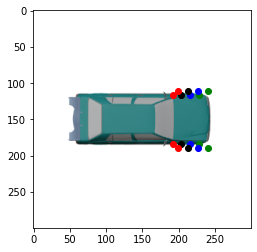

In [2]:
plt.figure()
plt.imshow(im)
# plt.scatter(x = loc_2d[3,0], y = loc_2d[3,1], c = 'r')
# plt.scatter(x = loc_2d[2,0], y = loc_2d[2,1], c = 'g')
# plt.scatter(x = loc_2d[6,0], y = loc_2d[6,1], c = 'b')
# plt.scatter(x = loc_2d[7,0], y = loc_2d[7,1], c = 'k')

interp = 0
# plt.scatter(x = loc_2d[4:,0], y = loc_2d[4:,1], c = 'g')
# plt.scatter(x = loc_2d[:,0], y = loc_2d[:,1], c = 'b')
# plt.scatter(x = loc_mid_2d[0,:,0], y = loc_mid_2d[0,:,1], c = 'b')
# plt.scatter(x = loc_mid_2d[-1,:,0], y = loc_mid_2d[-1,:,1], c = 'b')
plt.scatter(x = loc_mid_2d[interp + 1,:,0], y = loc_mid_2d[interp + 1,:,1], c = 'g')
plt.scatter(x = loc_mid_2d[interp + 2,:,0], y = loc_mid_2d[interp + 2,:,1], c = 'b')
plt.scatter(x = loc_mid_2d[interp + 3,:,0], y = loc_mid_2d[interp + 3,:,1], c = 'k')
plt.scatter(x = loc_mid_2d[interp + 4,:,0], y = loc_mid_2d[interp + 4,:,1], c = 'r')


In [104]:
import numpy as np
import torch
import pickle
import glob
import yaml
import time
import os

from utils import *
from marching_cubes_rgb import *
from scipy import ndimage
import matplotlib.pyplot as plt


import IPython


# INPUT FILE
SDF_DIR = "../../img_supervision/sdf/"

# IMAGES_PATH = "../../img_supervision/input_images/images/"
# ANNOTATIONS_PATH = "../../img_supervision/input_images/annotations.pkl"
IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"

PARAM_FILE = "config/param.yaml"


# SAVE FILE
PLOT_PATH = "../../img_supervision/plots/decoder/visuall_hull_SDF/"














if __name__ == '__main__':
    print("Loading parameters...")


    # get models' hashs
    list_model_hash = []
    for val in glob.glob(SDF_DIR + "*.h5"):
        list_model_hash.append(os.path.basename(val).split('.')[0])

    annotations = pickle.load(open(ANNOTATIONS_PATH, 'rb'))
    num_images_per_model = len(annotations[list_model_hash[0]])
    matrix_world_to_camera = annotations["matrix_world_to_camera"]
    matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
    


    model_id = 0
    num_pos_per_image = 1
    # num_images_per_model = 1

    model_hash = list_model_hash[model_id]
    model_annotations = annotations[model_hash].copy()
    frame = model_annotations[0]["frame"].copy()



    print("Loading sihlouettes")
    for image_id in range(num_images_per_model):
        image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
        input_im = imageio.imread(image_pth)

        mask_car = input_im.mean(2) == 255
        outside_dist = ndimage.distance_transform_edt(mask_car)
        inside_dist = - (ndimage.distance_transform_edt(1 - mask_car) -1)

        model_annotations[image_id]["2d_sdf"] = (outside_dist + inside_dist) / 300


        

Loading parameters...
Loading sihlouettes


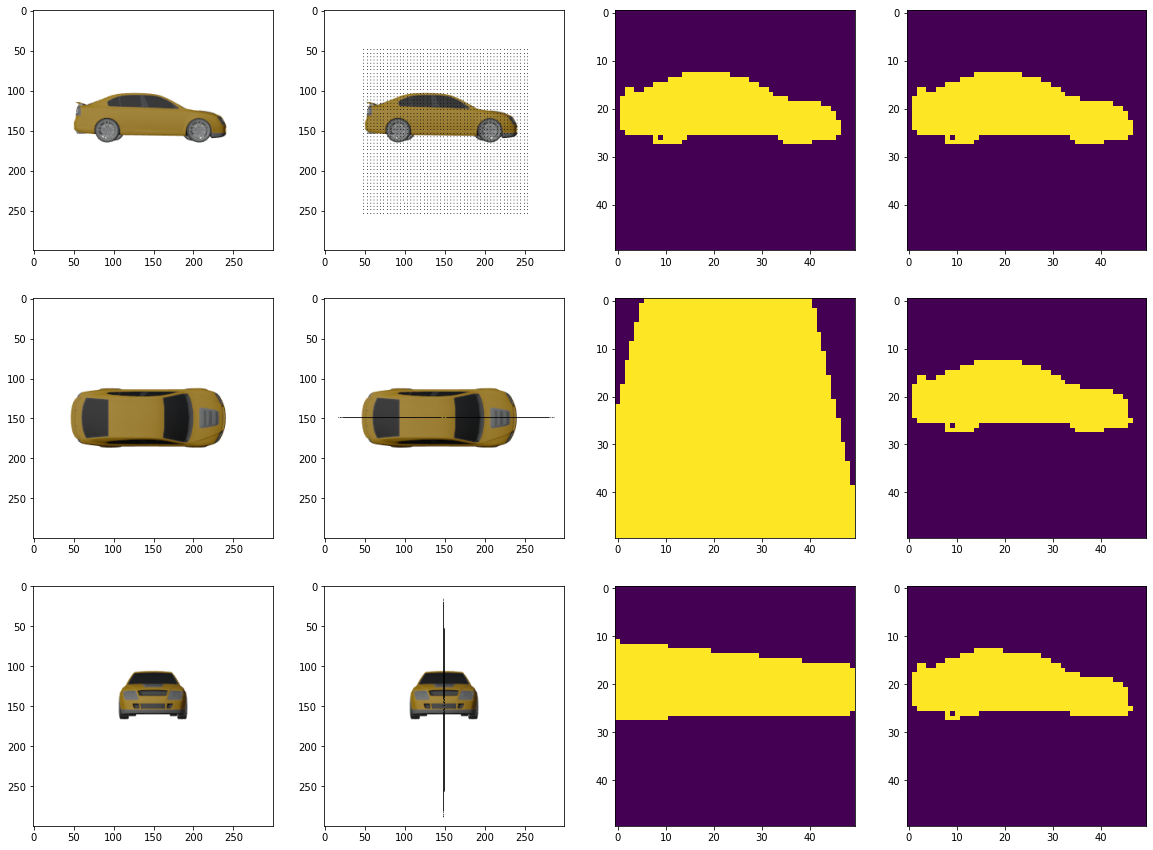

In [114]:
num_images = 3
image_shift = 0

# fig, axs = plt.subplots(num_images,6, figsize = (20,20))
fig, axs = plt.subplots(num_images,4, figsize = (20,15))
resolution = 50
intersection = np.ones([resolution, resolution]) * -1

for image_id in range(num_images):

    image_pth = IMAGES_PATH + model_hash + '/' + str(image_id + image_shift) + '.png'
    im = imageio.imread(image_pth)
    # loc_3d = model_annotations[image_id]['3d'].copy()
    matrix_object_to_world = model_annotations[image_id + image_shift]['matrix_object_to_world'].copy()
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    # plt.figure
    axs[image_id, 0].imshow(im)

    result_front = np.empty([resolution, resolution])
    projection = np.zeros([300,300])

    for x in range(resolution):
        for y in range(resolution):
            # pos_3d_ojbect = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            pos_3d_ojbect = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_ojbect = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])

            pos_3d_world = matrix_object_to_world[:3,:3].dot(pos_3d_ojbect)

            # pos_3d_world = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            # pos_3d_world = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_world = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])


            pos_2d = convert_w2c(matrix_world_to_camera, frame, pos_3d_world)

            # pos_2d[1] = 1 - pos_2d[1]
            pos_2d[:2] *= 300

            try:
                img_dist = model_annotations[image_id]["2d_sdf"][pos_2d[0].astype(int), pos_2d[1].astype(int)]
                projection[pos_2d[0].astype(int), pos_2d[1].astype(int)] = 1
            except:
                img_dist = 1e-10

            # result_front[x,y] = img_dist * pos_2d[2]
            result_front[resolution - 1 - x,resolution - 1 - y] = img_dist * pos_2d[2]

    intersection = np.maximum(intersection, result_front)

    # pc = axs[image_id,1].imshow(model_annotations[image_id]["2d_sdf"])
    # fig.colorbar(pc, ax = axs[image_id,1])

    # pc = axs[image_id,2].imshow(result_front)
    # fig.colorbar(pc, ax = axs[image_id,2])

    # axs[image_id,3].imshow(projection == 1)
    # axs[image_id,4].imshow(result_front <= 0)
    # axs[image_id,5].imshow(intersection <= 0)


    # axs[image_id,1].imshow(projection == 1)
    superposition = im
    superposition[projection == 1] = np.array([0,0,0])
    axs[image_id,1].imshow(superposition)
    axs[image_id,2].imshow(result_front <= 0)
    axs[image_id,3].imshow(intersection <= 0)





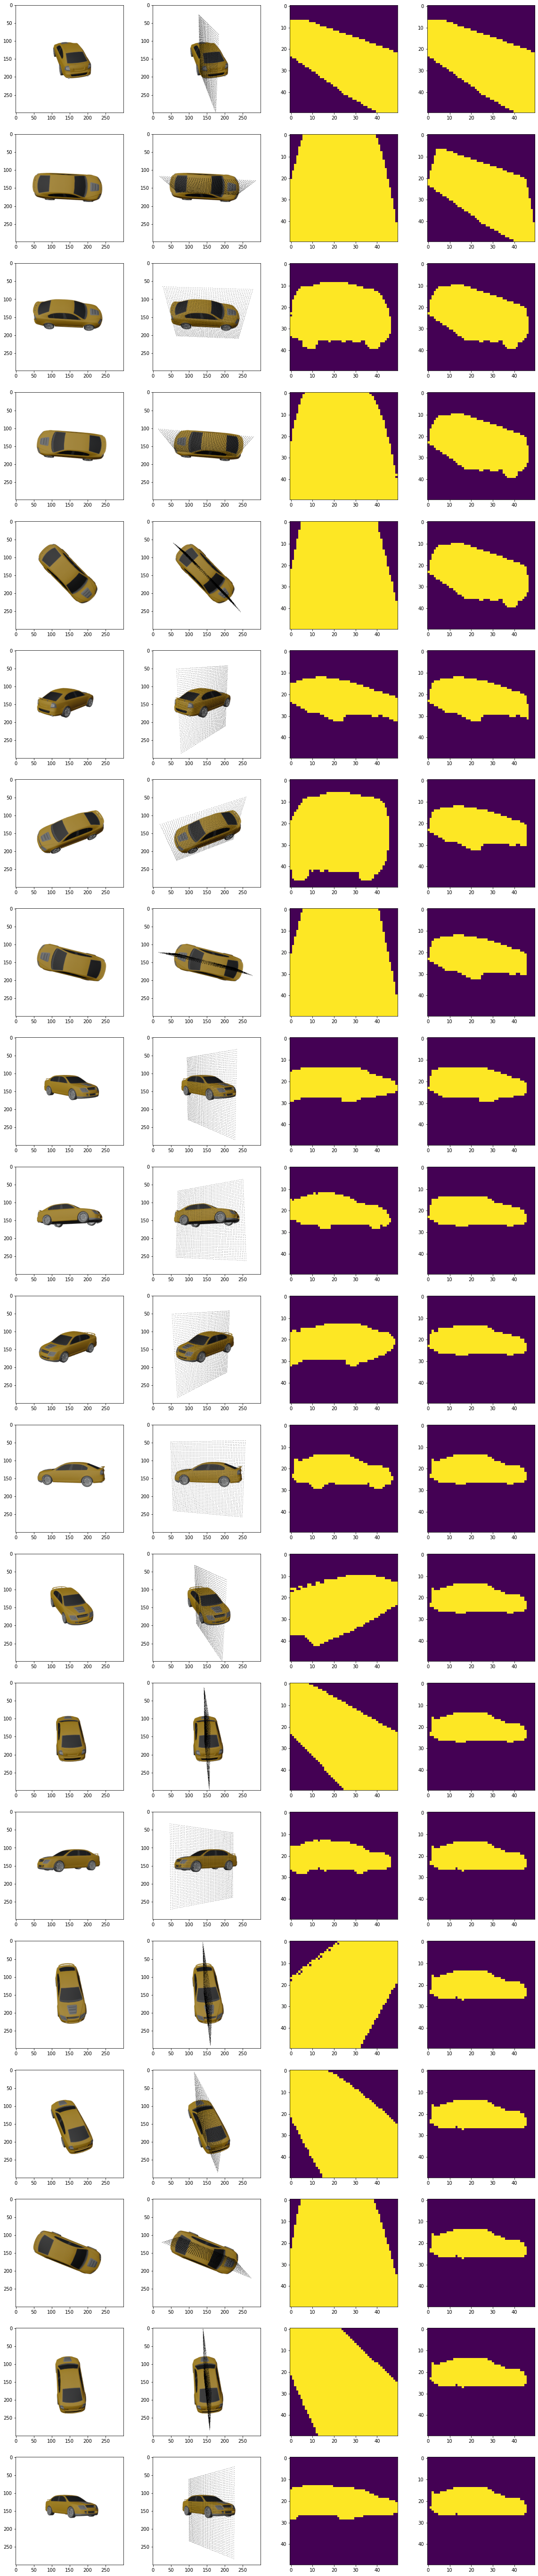

In [110]:
num_images = 20
image_shift = 3

# fig, axs = plt.subplots(num_images,6, figsize = (20,20))
fig, axs = plt.subplots(num_images,4, figsize = (20,100))
resolution = 50
intersection = np.ones([resolution, resolution]) * -1

for image_id in range(num_images):

    image_pth = IMAGES_PATH + model_hash + '/' + str(image_id + image_shift) + '.png'
    im = imageio.imread(image_pth)
    # loc_3d = model_annotations[image_id]['3d'].copy()
    matrix_object_to_world = model_annotations[image_id + image_shift]['matrix_object_to_world'].copy()
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    # plt.figure
    axs[image_id, 0].imshow(im)

    result_front = np.empty([resolution, resolution])
    projection = np.zeros([300,300])

    for x in range(resolution):
        for y in range(resolution):
            # pos_3d_ojbect = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            pos_3d_ojbect = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_ojbect = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])

            pos_3d_world = matrix_object_to_world[:3,:3].dot(pos_3d_ojbect)

            # pos_3d_world = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            # pos_3d_world = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_world = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])


            pos_2d = convert_w2c(matrix_world_to_camera, frame, pos_3d_world)

            # pos_2d[1] = 1 - pos_2d[1]
            pos_2d[:2] *= 300

            try:
                img_dist = model_annotations[image_id + image_shift]["2d_sdf"][pos_2d[0].astype(int), pos_2d[1].astype(int)]
                projection[pos_2d[0].astype(int), pos_2d[1].astype(int)] = 1
            except:
                img_dist = 1e-10

            # result_front[x,y] = img_dist * pos_2d[2]
            result_front[resolution - 1 - x,resolution - 1 - y] = img_dist * pos_2d[2]

    intersection = np.maximum(intersection, result_front)

    # pc = axs[image_id,1].imshow(model_annotations[image_id]["2d_sdf"])
    # fig.colorbar(pc, ax = axs[image_id,1])

    # pc = axs[image_id,2].imshow(result_front)
    # fig.colorbar(pc, ax = axs[image_id,2])

    # axs[image_id,3].imshow(projection == 1)
    # axs[image_id,4].imshow(result_front <= 0)
    # axs[image_id,5].imshow(intersection <= 0)


    # axs[image_id,1].imshow(projection == 1)
    superposition = im
    superposition[projection == 1] = np.array([0,0,0])
    axs[image_id,1].imshow(superposition)
    axs[image_id,2].imshow(result_front <= 0)
    axs[image_id,3].imshow(intersection <= 0)





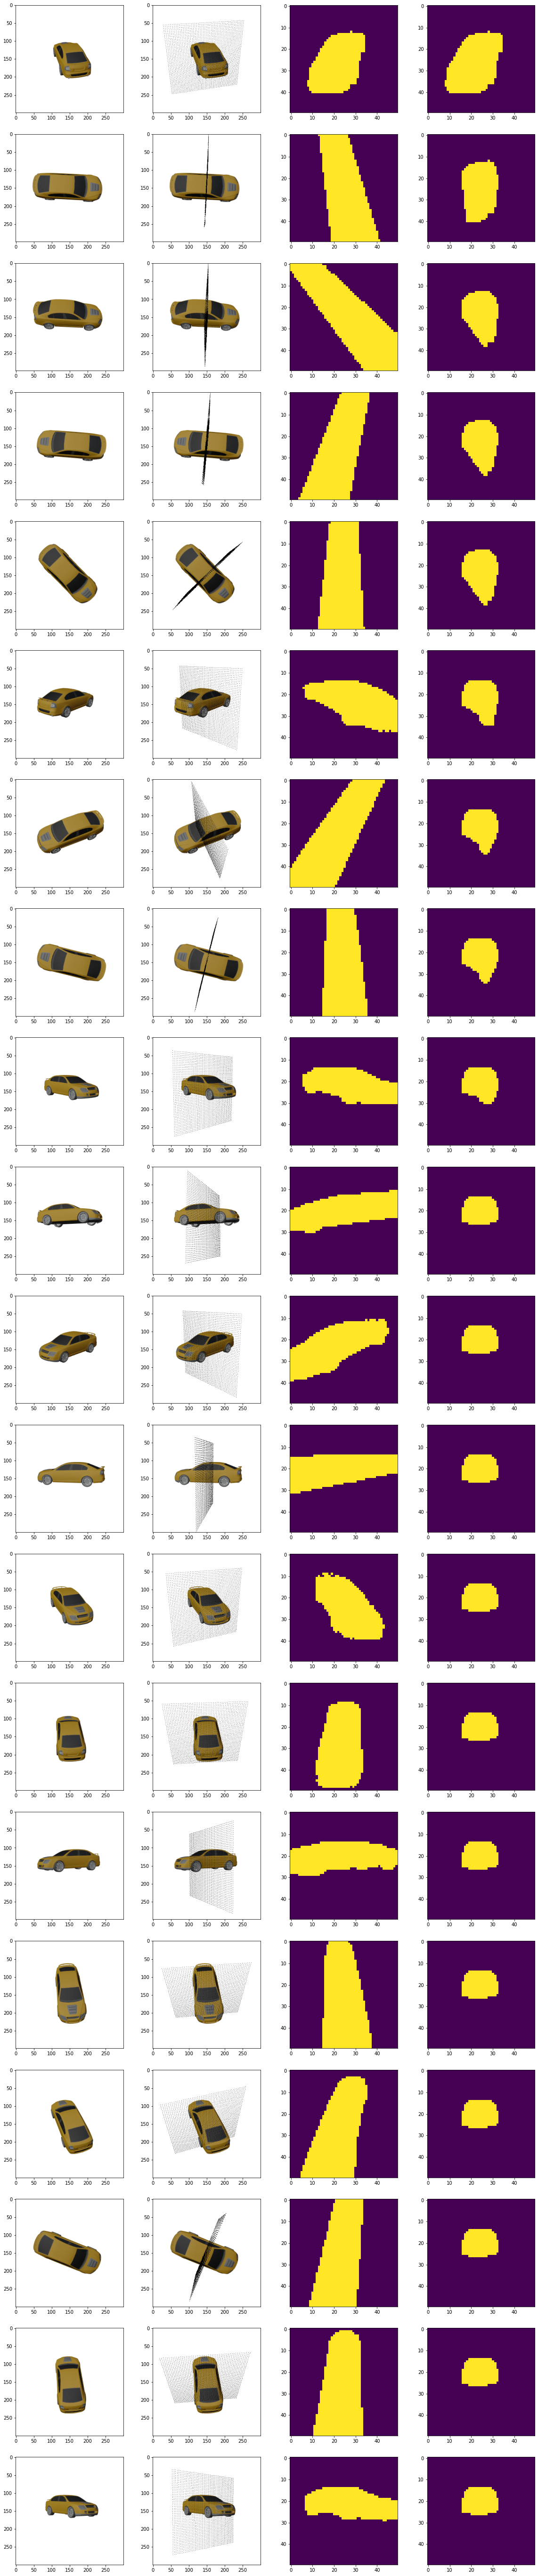

In [111]:
num_images = 20
image_shift = 3

# fig, axs = plt.subplots(num_images,6, figsize = (20,20))
fig, axs = plt.subplots(num_images,4, figsize = (20,100))
resolution = 50
intersection = np.ones([resolution, resolution]) * -1

for image_id in range(num_images):

    image_pth = IMAGES_PATH + model_hash + '/' + str(image_id + image_shift) + '.png'
    im = imageio.imread(image_pth)
    # loc_3d = model_annotations[image_id]['3d'].copy()
    matrix_object_to_world = model_annotations[image_id + image_shift]['matrix_object_to_world'].copy()
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    # plt.figure
    axs[image_id, 0].imshow(im)

    result_front = np.empty([resolution, resolution])
    projection = np.zeros([300,300])

    for x in range(resolution):
        for y in range(resolution):
            pos_3d_ojbect = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            # pos_3d_ojbect = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_ojbect = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])

            pos_3d_world = matrix_object_to_world[:3,:3].dot(pos_3d_ojbect)

            # pos_3d_world = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            # pos_3d_world = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_world = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])


            pos_2d = convert_w2c(matrix_world_to_camera, frame, pos_3d_world)

            # pos_2d[1] = 1 - pos_2d[1]
            pos_2d[:2] *= 300

            try:
                img_dist = model_annotations[image_id + image_shift]["2d_sdf"][pos_2d[0].astype(int), pos_2d[1].astype(int)]
                projection[pos_2d[0].astype(int), pos_2d[1].astype(int)] = 1
            except:
                img_dist = 1e-10

            # result_front[x,y] = img_dist * pos_2d[2]
            result_front[resolution - 1 - x,resolution - 1 - y] = img_dist * pos_2d[2]

    intersection = np.maximum(intersection, result_front)

    # pc = axs[image_id,1].imshow(model_annotations[image_id]["2d_sdf"])
    # fig.colorbar(pc, ax = axs[image_id,1])

    # pc = axs[image_id,2].imshow(result_front)
    # fig.colorbar(pc, ax = axs[image_id,2])

    # axs[image_id,3].imshow(projection == 1)
    # axs[image_id,4].imshow(result_front <= 0)
    # axs[image_id,5].imshow(intersection <= 0)


    # axs[image_id,1].imshow(projection == 1)
    superposition = im
    superposition[projection == 1] = np.array([0,0,0])
    axs[image_id,1].imshow(superposition)
    axs[image_id,2].imshow(result_front <= 0)
    axs[image_id,3].imshow(intersection <= 0)





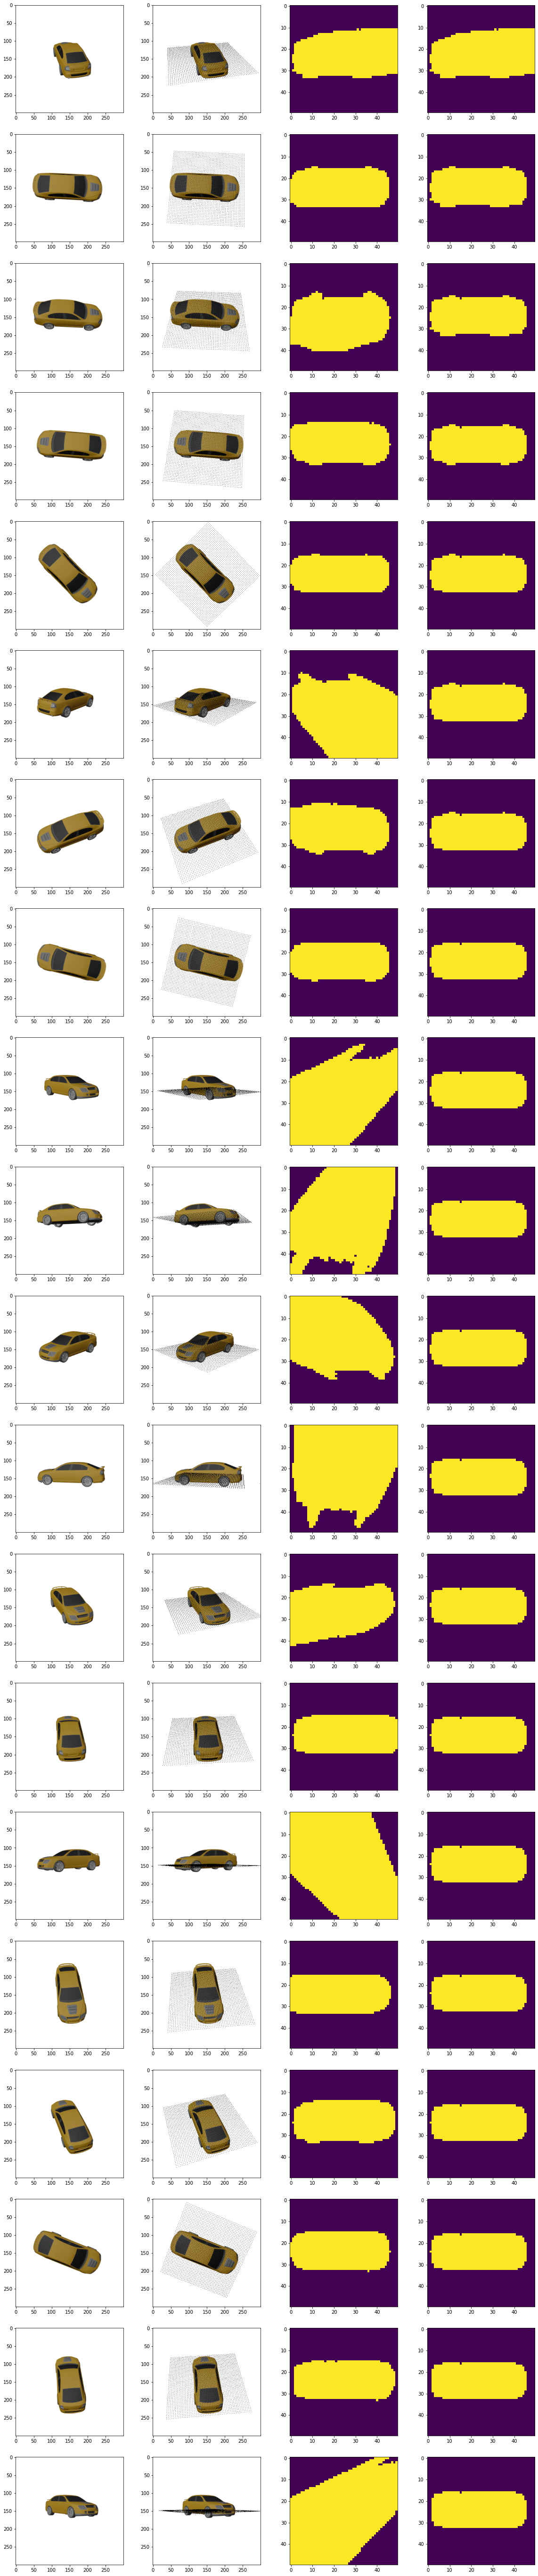

In [112]:
num_images = 20
image_shift = 3

# fig, axs = plt.subplots(num_images,6, figsize = (20,20))
fig, axs = plt.subplots(num_images,4, figsize = (20,100))
resolution = 50
intersection = np.ones([resolution, resolution]) * -1

for image_id in range(num_images):

    image_pth = IMAGES_PATH + model_hash + '/' + str(image_id + image_shift) + '.png'
    im = imageio.imread(image_pth)
    # loc_3d = model_annotations[image_id]['3d'].copy()
    matrix_object_to_world = model_annotations[image_id + image_shift]['matrix_object_to_world'].copy()
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    # plt.figure
    axs[image_id, 0].imshow(im)

    result_front = np.empty([resolution, resolution])
    projection = np.zeros([300,300])

    for x in range(resolution):
        for y in range(resolution):
            # pos_3d_ojbect = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            # pos_3d_ojbect = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            pos_3d_ojbect = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])

            pos_3d_world = matrix_object_to_world[:3,:3].dot(pos_3d_ojbect)

            # pos_3d_world = np.array([-0.5 + x * 0.02, -0.5 + y * 0.02, 0.0])
            # pos_3d_world = np.array([-0.5 + x * 0.02, 0.0, -0.5 + y * 0.02])
            # pos_3d_world = np.array([0, -0.5 + x * 0.02, -0.5 + y * 0.02])


            pos_2d = convert_w2c(matrix_world_to_camera, frame, pos_3d_world)

            # pos_2d[1] = 1 - pos_2d[1]
            pos_2d[:2] *= 300

            try:
                img_dist = model_annotations[image_id + image_shift]["2d_sdf"][pos_2d[0].astype(int), pos_2d[1].astype(int)]
                projection[pos_2d[0].astype(int), pos_2d[1].astype(int)] = 1
            except:
                img_dist = 1e-10

            # result_front[x,y] = img_dist * pos_2d[2]
            result_front[resolution - 1 - x,resolution - 1 - y] = img_dist * pos_2d[2]

    intersection = np.maximum(intersection, result_front)

    # pc = axs[image_id,1].imshow(model_annotations[image_id]["2d_sdf"])
    # fig.colorbar(pc, ax = axs[image_id,1])

    # pc = axs[image_id,2].imshow(result_front)
    # fig.colorbar(pc, ax = axs[image_id,2])

    # axs[image_id,3].imshow(projection == 1)
    # axs[image_id,4].imshow(result_front <= 0)
    # axs[image_id,5].imshow(intersection <= 0)


    # axs[image_id,1].imshow(projection == 1)
    superposition = im
    superposition[projection == 1] = np.array([0,0,0])
    axs[image_id,1].imshow(superposition)
    axs[image_id,2].imshow(result_front <= 0)
    axs[image_id,3].imshow(intersection <= 0)





In [71]:
b = result_front

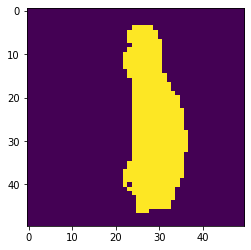

In [99]:
plt.imshow((a < 0) * (b<0))

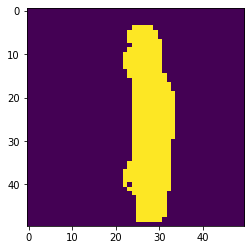

In [75]:
plt.imshow((a < 0) * (b < 0))

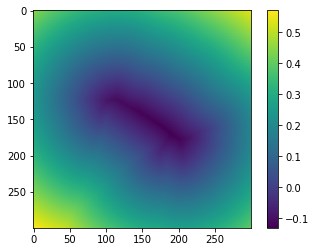

In [4]:

import matplotlib.pyplot as plt
import cv2

mask_car = input_im.mean(2) == 255

from scipy import ndimage
outside_dist = ndimage.distance_transform_edt(mask_car)
inside_dist = - (ndimage.distance_transform_edt(1 - mask_car) -1)

a = (outside_dist + inside_dist)/300

mask_sil = a == 0


plt.imshow(a)
# plt.imshow(mask_sil)
plt.colorbar()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import glob
import yaml
import time
import os

from utils import *
from marching_cubes_rgb import *
from scipy import ndimage
from networks import Decoder
from dataLoader import DatasetDecoderSDF2



import IPython

# INPUT FILE
SDF_DIR = "../../img_supervision/sdf/"

# IMAGES_PATH = "../../img_supervision/input_images/images/"
# ANNOTATIONS_PATH = "../../img_supervision/input_images/annotations.pkl"
IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"
PARAM_FILE = "config/param.yaml"

# SAVE FILE
PLOT_PATH = "../../img_supervision/plots/decoder/visuall_hull_SDF/"


def init_weights(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Conv3d)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def init_opt_sched(decoder, param):
    """ initialize optimizer and scheduler"""

    optimizer_decoder = torch.optim.Adam(
        [
            {
                "params": decoder.parameters(),
                "lr": param["eta_decoder"],
            },
        ]
    )

    scheduler_decoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_decoder, gamma=param["gamma_decoder_LR"])

    return optimizer_decoder, scheduler_decoder



def init_xyz(resolution):
    """ fill 3d grid representing 3d location to give as input to the decoder """
    xyz = torch.empty(resolution * resolution * resolution, 3).cuda()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xyz[x * resolution * resolution + y * resolution + z, :] = torch.Tensor([x/(resolution-1)-0.5,y/(resolution-1)-0.5,z/(resolution-1)-0.5])

    return xyz


def compute_loss_sdf(pred_sdf, sdf_gt, threshold_precision, lambda_sdf):
    """ compute sdf, rgb and regression loss """

    loss = torch.nn.MSELoss(reduction='none')

    # assign weight of 0 for easy samples that are well trained
    weight_sdf = ~((pred_sdf > threshold_precision).squeeze() * (sdf_gt > threshold_precision).squeeze()) \
        * ~((pred_sdf < -threshold_precision).squeeze() * (sdf_gt < -threshold_precision).squeeze())

    #L2 loss, only for hard samples
    loss_sdf = loss(pred_sdf.squeeze(), sdf_gt)
    loss_sdf = (loss_sdf * weight_sdf).sum()/weight_sdf.count_nonzero()
    loss_sdf *= lambda_sdf

    return loss_sdf
    


def compute_time_left(time_start, samples_count, num_samples, epoch, num_epoch):
    """ Compute time left until the end of training """
    time_passed = time.time() - time_start
    num_samples_seen = epoch * num_samples + samples_count
    time_per_sample = time_passed/num_samples_seen
    estimate_total_time = time_per_sample * num_epoch * num_samples
    estimate_time_left = estimate_total_time - time_passed

    return estimate_time_left


if __name__ == '__main__':
    print("Loading parameters...")


    # load parameters
    param_all = yaml.safe_load(open(PARAM_FILE))
    param_sdf = param_all["decoder_learning_sdf"]


    # get models' hashs
    list_model_hash = []
    for val in glob.glob(SDF_DIR + "*.h5"):
        list_model_hash.append(os.path.basename(val).split('.')[0])

    annotations = pickle.load(open(ANNOTATIONS_PATH, 'rb'))
    num_images_per_model = len(annotations[list_model_hash[0]])
    matrix_world_to_camera = annotations["matrix_world_to_camera"]
    matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
    


    model_id = 0
    num_pos_per_image = 1
    # num_images_per_model = 1

    model_hash = list_model_hash[model_id]
    model_annotations = annotations[model_hash].copy()
    frame = model_annotations[0]["frame"].copy()



    print("Loading sihlouettes")
    for image_id in range(num_images_per_model):
        image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
        input_im = imageio.imread(image_pth)

        mask_car = input_im.mean(2) == 255
        outside_dist = ndimage.distance_transform_edt(mask_car)
        inside_dist = - (ndimage.distance_transform_edt(1 - mask_car) -1)

        model_annotations[image_id]["2d_sdf"] = (outside_dist + inside_dist) / 300


        

Using skimage's marching cubes implementation.
Loading parameters...
Loading sihlouettes


In [9]:

intersection = pickle.load(open(PLOT_PATH + "pred_64_100.pkl", 'rb'))
intersection = intersection[:,:,:,0].squeeze().astype(np.float32)

resolution = len(intersection)

intersection = intersection.reshape(resolution * resolution * resolution)
threshold_precision = 1/resolution
num_samples = resolution * resolution * resolution

latent_code = torch.zeros(param_all["latent_size"]).cuda()


# fill a xyz grid to give as input to the decoder 
xyz = init_xyz(resolution)


decoder_sdf = Decoder(param_all["latent_size"], "sdf", batch_norm=True).cuda()
decoder_sdf.apply(init_weights)
decoder_sdf.train()

decoder_rgb = Decoder(param_all["latent_size"], "rgb", batch_norm=True).cuda()
decoder_rgb.apply(init_weights)
decoder_rgb.train()


optimizer_decoder, scheduler_decoder = init_opt_sched(decoder_sdf, param_sdf["optimizer"])

# Init dataset and dataloader
training_dataset = DatasetDecoderSDF2(intersection)
training_generator = torch.utils.data.DataLoader(training_dataset, **param_sdf["dataLoader"])




In [10]:
time_start = time.time()

for epoch in range(param_sdf["num_epoch"]):

    samples_count = 0

    for sdf_gt, xyz_idx in training_generator:
        optimizer_decoder.zero_grad()

        batch_size = len(sdf_gt)

        sdf_gt = sdf_gt.cuda()

        pred_sdf = decoder_sdf(latent_code.unsqueeze(0).repeat(batch_size, 1), xyz[xyz_idx])

        loss_sdf = compute_loss_sdf(pred_sdf, sdf_gt, threshold_precision, param_sdf["lambda_sdf"])


        #update weights
        loss_sdf.backward()

        optimizer_decoder.step()

        samples_count += batch_size


        print(f"loss_sdf: {loss_sdf}")


        # estime time left
        time_left = compute_time_left(time_start, samples_count, num_samples, epoch, param_sdf["num_epoch"])

        print(f"time left: {time_left}")



    scheduler_decoder.step()



loss_sdf: 0.00979518610984087
time left: 2073.185745763779
loss_sdf: 0.010074037127196789
time left: 1068.554098405838
loss_sdf: 0.0041005429811775684
time left: 731.1830408350627
loss_sdf: 0.0021117657888680696
time left: 562.0452411079407
loss_sdf: 0.0009732084581628442
time left: 460.09055460548404
loss_sdf: 0.0007522377418354154
time left: 391.9159738922119
loss_sdf: 0.0008575440151616931
time left: 351.70836230686734
loss_sdf: 0.0007057534530758858
time left: 313.2133751964569
loss_sdf: 0.00023735374270472676
time left: 283.91332019911874
loss_sdf: 0.0006647910922765732
time left: 260.0863516559601
loss_sdf: 0.0005053644999861717
time left: 240.7023337086764
loss_sdf: 0.0005600498407147825
time left: 224.6530678462982
loss_sdf: 0.00034531738492660224
time left: 211.54003678468558
loss_sdf: 0.0005387971177697182
time left: 199.9115350505284
loss_sdf: 0.0002998523705173284
time left: 189.98488929748535
loss_sdf: 0.0004032850556541234
time left: 180.89096225738527
loss_sdf: 0.0003163

In [33]:
intersection = pickle.load(open(PLOT_PATH + "pred_64_100.pkl", 'rb'))


# variable to store results
sdf_result = np.empty([resolution, resolution, resolution, 4])

pred_all = np.empty([resolution * resolution, 4])

decoder_sdf.eval()

# loop because it requires too much GPU memory on my computer
for x in range(resolution):
    xyz_sub_sample = xyz[x * resolution * resolution: (x+1) * resolution * resolution]

    pred_sdf = decoder_sdf(latent_code.unsqueeze(0).repeat(resolution * resolution, 1), xyz_sub_sample).detach().cpu()
    pred_sdf = pred_sdf * resolution

    pred_rgb = decoder_rgb(latent_code.unsqueeze(0).repeat(resolution * resolution, 1), xyz_sub_sample).detach().cpu()
    pred_rgb = torch.clamp(pred_rgb, 0, 1)
    pred_rgb = pred_rgb * 255

    pred_all[:,0] = pred_sdf.squeeze()
    pred_all[:,1:] = pred_rgb

    sdf_result[x, :, :, :] = np.reshape(pred_all, [resolution, resolution, 4])

    # print(abs(np.reshape(pred_all, [resolution, resolution, 4]) -  64 *  intersection[x]).mean())

    # sdf_result[x, :, :, :] = intersection[x]

if(np.min(sdf_result[:,:,:,0]) < 0 and np.max(sdf_result[:,:,:,0]) > 0):
    vertices_pred, faces_pred = marching_cubes(sdf_result[:,:,:,0])
    colors_v_pred = exctract_colors_v(vertices_pred, sdf_result)
    colors_f_pred = exctract_colors_f(colors_v_pred, faces_pred)
    off_file = "%s/pred_from_sdf.off" %(PLOT_PATH)
    write_off(off_file, vertices_pred, faces_pred, colors_f_pred)
    print("Wrote pred_from_sdf.off")
else:
    print("surface level: 0, should be comprise in between the minimum and maximum value")




/home/loic/MasterPDM/codePDM/img_supervision/marching_cubes_rgb.py:100: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, faces, normals, values = measure.marching_cubes_lewiner(tensor.transpose(1, 0, 2), 0)


Wrote pred_from_sdf.off


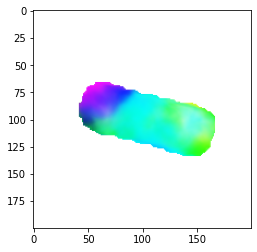

In [41]:
image_id = 10


ground_truth_image, pos_init_ray, ray_marching_vector, min_step, max_step = initialize_rendering_image(model_hash, image_id, annotations, IMAGES_PATH)

pos_init_ray = torch.tensor(pos_init_ray, dtype=torch.float).cuda()
ray_marching_vector = torch.tensor(ray_marching_vector, dtype=torch.float).cuda()
min_step = torch.tensor(min_step, dtype=torch.float).cuda()
max_step = torch.tensor(max_step, dtype=torch.float).cuda()

pos_along_ray = get_pos_from_ray_marching(decoder_sdf, latent_code, pos_init_ray, ray_marching_vector, min_step, max_step).cuda()

pos_along_ray = interpolate_final_pos(pos_along_ray, resolution=50, scaling_factor=4)


rendered_image, mask_car = render_image_from_pos(decoder_sdf, decoder_rgb, pos_along_ray, latent_code, resolution=50, scaling_factor=4)

plt.imshow(rendered_image.cpu().detach().numpy())

In [26]:
# compute ground truth SDF


num_images = 100
resolution = 64

step = 1/resolution

intersection = np.empty([resolution, resolution, resolution, 4])
intersection[:,:,:,0] = -1e42
intersection[:,:,:,1:] = 1




for image_id in range(num_images):

    print(image_id)

    matrix_object_to_world = model_annotations[image_id]['matrix_object_to_world'].copy()
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    result_from_image = np.empty([resolution, resolution, resolution])

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                pos_3d_ojbect = np.array([-0.5 + x * step, -0.5 + y * step, -0.5 + z * step])
                pos_3d_world = matrix_object_to_world[:3,:3].dot(pos_3d_ojbect)
                pos_2d = convert_w2c(matrix_world_to_camera, frame, pos_3d_world)
                pos_2d[:2] *= 300

                try:
                    img_dist = model_annotations[image_id]["2d_sdf"][pos_2d[0].astype(int), pos_2d[1].astype(int)]
                except:
                    img_dist = 1e-10

                # result_from_image[resolution - 1 - x, resolution - 1 - y, resolution - 1 - z] = img_dist * pos_2d[2]
                result_from_image[x,y,z] = img_dist * pos_2d[2]

    intersection[:,:,:,0] = np.maximum(intersection[:,:,:,0], result_from_image)






0
1


In [9]:

if(np.min(intersection[:,:,:,0]) < 0 and np.max(intersection[:,:,:,0]) > 0):
    vertices_pred, faces_pred = marching_cubes(intersection[:,:,:,0])
    colors_v_pred = exctract_colors_v(vertices_pred, intersection)
    colors_f_pred = exctract_colors_f(colors_v_pred, faces_pred)
    off_file = "%s/pred_%d_%d.off" %(PLOT_PATH, resolution, num_images)
    write_off(off_file, vertices_pred, faces_pred, colors_f_pred)
    with open(PLOT_PATH + f"pred_{resolution}_{num_images}.pkl", "wb") as file:
        pickle.dump(intersection, file)
    print(f"Wrote pred_{resolution}_{num_images}.off")
else:
    print("surface level: 0, should be comprise in between the minimum and maximum value")




Wrote pred_64_100.off


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import glob
import yaml
import time
import os

from utils import *
from marching_cubes_rgb import *
from scipy import ndimage
from networks import Decoder
from dataLoader import DatasetDecoderSDF3

import IPython

MODEL_ID = 0
MAX_IMAGES = 20
RESOLUTION = 64

# INPUT FILE
SDF_DIR = "../../img_supervision/sdf/"


# IMAGES_PATH = "../../img_supervision/input_images/images/"
# ANNOTATIONS_PATH = "../../img_supervision/input_images/annotations.pkl"
IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"
PARAM_FILE = "config/param.yaml"

# SAVE FILE
PLOT_PATH = "../../img_supervision/plots/decoder/visuall_hull_SDF/"
DECODER_SDF_PATH = "models_and_codes/decoder_sdf.pth"



def init_weights(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Conv3d)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def init_opt_sched(decoder, param):
    """ initialize optimizer and scheduler"""

    optimizer_decoder = torch.optim.Adam(
        [
            {
                "params": decoder.parameters(),
                "lr": param["eta_decoder"],
            },
        ]
    )

    scheduler_decoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_decoder, gamma=param["gamma_decoder_LR"])

    return optimizer_decoder, scheduler_decoder

def init_xyz(resolution):
    """ fill 3d grid representing 3d location to give as input to the decoder """
    xyz = torch.empty(resolution * resolution * resolution, 3).cuda()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xyz[x * resolution * resolution + y * resolution + z, :] = torch.Tensor([x/(resolution-1)-0.5,y/(resolution-1)-0.5,z/(resolution-1)-0.5])

    return xyz

def compute_loss_sdf(pred_sdf, sdf_gt, threshold_precision, lambda_sdf):
    """ compute sdf, rgb and regression loss """

    loss = torch.nn.MSELoss(reduction='none')

    # assign weight of 0 for easy samples that are well trained
    weight_sdf = ~((pred_sdf > threshold_precision).squeeze() * (sdf_gt > threshold_precision).squeeze()) \
        * ~((pred_sdf < -threshold_precision).squeeze() * (sdf_gt < -threshold_precision).squeeze())

    #L2 loss, only for hard samples
    loss_sdf = loss(pred_sdf.squeeze(), sdf_gt)
    loss_sdf = (loss_sdf * weight_sdf).sum()/weight_sdf.count_nonzero()
    loss_sdf *= lambda_sdf

    return loss_sdf
    
def compute_time_left(time_start, samples_count, num_samples):
    """ Compute time left until the end of training """
    time_passed = time.time() - time_start
    num_samples_seen = samples_count
    time_per_sample = time_passed/num_samples_seen
    estimate_total_time = time_per_sample * num_samples
    estimate_time_left = estimate_total_time - time_passed

    return estimate_time_left


if __name__ == '__main__':
    print("Loading parameters...")

    # load parameters
    param_all = yaml.safe_load(open(PARAM_FILE))
    param_sdf = param_all["decoder_learning_sdf"]

    # get models' hashs
    list_model_hash = []
    for val in glob.glob(SDF_DIR + "*.h5"):
        list_model_hash.append(os.path.basename(val).split('.')[0])

    annotations = pickle.load(open(ANNOTATIONS_PATH, 'rb'))
    num_images_per_model = len(annotations[list_model_hash[0]])
    num_images = min(num_images_per_model, MAX_IMAGES)
    
    model_id = MODEL_ID
    model_hash = list_model_hash[model_id]
    model_annotations = annotations[model_hash].copy()

    resolution = RESOLUTION
    threshold_precision = 1/resolution
    num_samples = resolution * resolution * resolution


    frame = model_annotations[0]["frame"].copy()

    matrix_world_to_camera = annotations["matrix_world_to_camera"]
    matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]

    print("Loading sihlouettes...")
    for image_id in range(num_images_per_model):
        image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
        input_im = imageio.imread(image_pth)

        mask_car = input_im.mean(2) == 255
        outside_dist = ndimage.distance_transform_edt(mask_car)
        inside_dist = - (ndimage.distance_transform_edt(1 - mask_car) -1)

        model_annotations[image_id]["2d_sdf"] = (outside_dist + inside_dist) / 300





Loading parameters...
Loading sihlouettes...


In [4]:

latent_code = torch.zeros(param_all["latent_size"]).cuda()

decoder_sdf = Decoder(param_all["latent_size"], "sdf", batch_norm=True).cuda()
decoder_sdf.apply(init_weights)
decoder_sdf.train()

decoder_rgb = Decoder(param_all["latent_size"], "rgb", batch_norm=True).cuda()
decoder_rgb.apply(init_weights)
decoder_rgb.train()

optimizer_decoder, scheduler_decoder = init_opt_sched(decoder_sdf, param_sdf["optimizer"])


num_samples = 1000 * 1000

# Init dataset and dataloader
training_dataset = DatasetDecoderSDF3(num_samples, num_images, matrix_world_to_camera, frame, model_annotations)
training_generator = torch.utils.data.DataLoader(training_dataset, **param_sdf["dataLoader"])


In [5]:
samples_count = 0
time_start = time.time()

for pos_3d_world, sdf_estimation in training_generator:
    optimizer_decoder.zero_grad()
    batch_size = len(pos_3d_world)

    pos_3d_world = pos_3d_world.float().cuda()
    sdf_estimation = sdf_estimation.float().cuda()

    pred_sdf = decoder_sdf(latent_code.unsqueeze(0).repeat(batch_size, 1), pos_3d_world)

    loss_sdf = compute_loss_sdf(pred_sdf, sdf_estimation, threshold_precision, param_sdf["lambda_sdf"])

    #update weights
    loss_sdf.backward()
    optimizer_decoder.step()
    scheduler_decoder.step()
    samples_count += batch_size

    time_left = compute_time_left(time_start, samples_count, num_samples)

    print(f"loss_sdf: {loss_sdf}")
    print(f"time left: {time_left}")


loss_sdf: 0.011694495566189289
time left: 3691.749853849411
loss_sdf: 0.0423753447830677
time left: 1870.5050044059753
loss_sdf: 0.007896741852164268
time left: 1251.5545081297557
loss_sdf: 0.0035578899551182985
time left: 945.6805336475372
loss_sdf: 0.003738081082701683
time left: 760.8335456848145
loss_sdf: 0.002560886787250638
time left: 637.3538921674092
loss_sdf: 0.001987108960747719
time left: 550.176590681076
loss_sdf: 0.0007231099880300462
time left: 483.27812004089355
loss_sdf: 0.00085636624135077
time left: 757.7742935551538
loss_sdf: 0.000959765980951488
time left: 683.870189666748
loss_sdf: 0.000516328786034137
time left: 624.4530565738678
loss_sdf: 0.000625776476226747
time left: 573.9816837310791
loss_sdf: 0.0007147116120904684
time left: 531.3221390247345
loss_sdf: 0.0005288859247229993
time left: 494.8261070251465
loss_sdf: 0.0002938419347628951
time left: 463.6180136203766
loss_sdf: 0.0006846158648841083
time left: 436.26408541202545
loss_sdf: 0.000539421453140676
time

In [6]:

# fill a xyz grid to give as input to the decoder 
xyz = init_xyz(resolution)

In [7]:

# variable to store results
sdf_result = np.empty([resolution, resolution, resolution, 4])
pred_all = np.empty([resolution * resolution, 4])

decoder_sdf.eval()

# loop because it requires too much GPU memory on my computer
for x in range(resolution):
    xyz_sub_sample = xyz[x * resolution * resolution: (x+1) * resolution * resolution]

    pred_sdf = decoder_sdf(latent_code.unsqueeze(0).repeat(resolution * resolution, 1), xyz_sub_sample).detach().cpu()
    pred_sdf = pred_sdf * resolution

    pred_rgb = decoder_rgb(latent_code.unsqueeze(0).repeat(resolution * resolution, 1), xyz_sub_sample).detach().cpu()
    pred_rgb = torch.clamp(pred_rgb, 0, 1)
    pred_rgb = pred_rgb * 255

    pred_all[:,0] = pred_sdf.squeeze()
    pred_all[:,1:] = pred_rgb

    sdf_result[x, :, :, :] = np.reshape(pred_all, [resolution, resolution, 4])


if(np.min(sdf_result[:,:,:,0]) < 0 and np.max(sdf_result[:,:,:,0]) > 0):
    vertices_pred, faces_pred = marching_cubes(sdf_result[:,:,:,0])
    colors_v_pred = exctract_colors_v(vertices_pred, sdf_result)
    colors_f_pred = exctract_colors_f(colors_v_pred, faces_pred)
    off_file = "%s/pred_from_sdf_continuous.off" %(PLOT_PATH)
    write_off(off_file, vertices_pred, faces_pred, colors_f_pred)
    print("Wrote pred_from_sdf_continuous.off")
else:
    print("surface level: 0, should be comprise in between the minimum and maximum value")


/home/loic/MasterPDM/codePDM/img_supervision/marching_cubes_rgb.py:100: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, faces, normals, values = measure.marching_cubes_lewiner(tensor.transpose(1, 0, 2), 0)


Wrote pred_from_sdf_continuous.off


In [169]:
import numpy as np
from numpy.core.numeric import count_nonzero
from numpy.random.mtrand import sample
import torch
import pickle
import glob
import yaml
import time
import matplotlib.pyplot as plt

from networks import Decoder
from dataLoader import DatasetDecoderTrainingRGB_2, DatasetDecoderValidationRGB_2
from utils import *

from marching_cubes_rgb import *

import IPython

MODEL_ID = 0


# INPUT FILE
SDF_DIR = "../../img_supervision/sdf/"
# IMAGES_PATH = "../../img_supervision/input_images/images/"
# ANNOTATIONS_PATH = "../../img_supervision/input_images/annotations.pkl"
IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"
PARAM_FILE = "config/param.yaml"
DECODER_SDF_PATH = "models_and_codes/decoder_sdf.pth"

# load parameters
param_all = yaml.safe_load(open(PARAM_FILE))
param_rgb = param_all["decoder_learning_rgb"]

# get models' hashs
list_model_hash = []
for val in glob.glob(SDF_DIR + "*.h5"):
    list_model_hash.append(os.path.basename(val).split('.')[0])

image_id = 0
model_id = MODEL_ID
model_hash = list_model_hash[model_id]

annotations = pickle.load(open(ANNOTATIONS_PATH, 'rb'))
num_images_per_model = len(annotations[list_model_hash[0]])
matrix_world_to_camera = annotations["matrix_world_to_camera"]
frame = annotations[model_hash][image_id]['frame'].copy()


decoder_sdf = torch.load(DECODER_SDF_PATH).cuda()
decoder_sdf.eval()


decoder_rgb = Decoder(param_all["latent_size"], "rgb", batch_norm=True).cuda()
decoder_rgb.train()


ground_truth_image, pos_init_ray, ray_marching_vector, min_step, max_step = initialize_rendering_image(model_hash, image_id, annotations, IMAGES_PATH)

ground_truth_image = np.array(ground_truth_image)

pos_init_ray = torch.tensor(pos_init_ray, dtype=torch.float).cuda()
ray_marching_vector = torch.tensor(ray_marching_vector, dtype=torch.float).cuda()
min_step = torch.tensor(min_step, dtype=torch.float).cuda()
max_step = torch.tensor(max_step, dtype=torch.float).cuda()

latent_code = torch.zeros(param_all["latent_size"]).cuda()

pos_along_ray = get_pos_from_ray_marching(decoder_sdf, latent_code, pos_init_ray, ray_marching_vector, min_step, max_step)
pos_along_ray = interpolate_final_pos(pos_along_ray, resolution=250, scaling_factor=1)
rendered_image, mask_car = render_image_from_pos(decoder_sdf, decoder_rgb, pos_along_ray, latent_code, resolution=250, scaling_factor=1)
rescale_ground_truth_image = cv2.resize(np.squeeze(ground_truth_image), rendered_image.shape[:2])
# rescale_ground_truth_image = torch.tensor(rescale_ground_truth_image,dtype=torch.float).cuda()

step = torch.zeros(len(pos_along_ray)).cuda()
step[min_step.cpu().numpy() == 0 ] = 2

pos_along_ray = pos_along_ray + step.unsqueeze(1).mul(ray_marching_vector)

pos_along_ray = pos_along_ray.cpu().numpy()
mask_car = mask_car.reshape(250*250).cpu().numpy()


In [173]:
image_id_1 = image_id
image_id_2 = 12

pos_2d_view_1 = np.ones([len(pos_along_ray), 2])
pos_2d_view_2 = np.ones([len(pos_along_ray), 2])

matrix_object_to_world = annotations[model_hash][image_id_1]['matrix_object_to_world'].copy()
matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]


for i in range(len(pos_along_ray)):
    pos_2d_view_1[i] = convert_w2c(matrix_world_to_camera, frame, np.dot(matrix_object_to_world[:3,:3],(pos_along_ray[i])))[:2]

    pos_2d_view_1[i,0] = pos_2d_view_1[i,0] * rescale_ground_truth_image.shape[0]
    pos_2d_view_1[i,1] = pos_2d_view_1[i,1] * rescale_ground_truth_image.shape[1]

pos_2d_view_1 = pos_2d_view_1.astype(int)
pos_2d_view_1[pos_2d_view_1 == 250] = 249


matrix_object_to_world = annotations[model_hash][image_id_2]['matrix_object_to_world'].copy()
matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]


for i in range(len(pos_along_ray)):
    pos_2d_view_2[i] = convert_w2c(matrix_world_to_camera, frame, np.dot(matrix_object_to_world[:3,:3],(pos_along_ray[i])))[:2]

    pos_2d_view_2[i,0] = pos_2d_view_2[i,0] * rescale_ground_truth_image.shape[0]
    pos_2d_view_2[i,1] = pos_2d_view_2[i,1] * rescale_ground_truth_image.shape[1]

pos_2d_view_2 = pos_2d_view_2.astype(int)



In [174]:
reconstructed_original_view = np.ones_like(rescale_ground_truth_image)
reconstructed_new_view = np.ones_like(rescale_ground_truth_image)

for i in range(len(pos_2d_view_1)):
    if mask_car[i]:
        reconstructed_original_view[pos_2d_view_1[i][1], pos_2d_view_1[i][0]] = rescale_ground_truth_image[pos_2d_view_1[i][1], pos_2d_view_1[i][0]]
        reconstructed_new_view[pos_2d_view_2[i][1], pos_2d_view_2[i][0]] = rescale_ground_truth_image[pos_2d_view_1[i][1], pos_2d_view_1[i][0]]


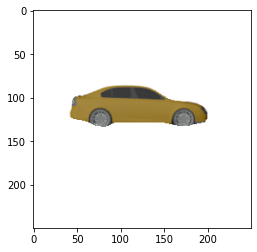

In [175]:
plt.imshow(reconstructed_original_view)

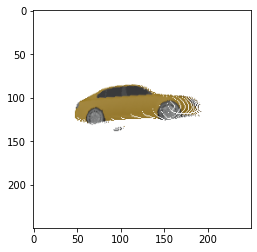

In [176]:
plt.imshow(reconstructed_new_view)

In [178]:
image_pth = IMAGES_PATH + model_hash + '/' + str(image_id_2) + '.png'
ground_truth_image_target = np.array(imageio.imread(image_pth))/255
rescale_ground_truth_image_target = cv2.resize(np.squeeze(ground_truth_image_target), rendered_image.shape[:2])


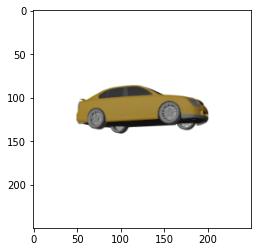

In [179]:
plt.imshow(rescale_ground_truth_image_target)

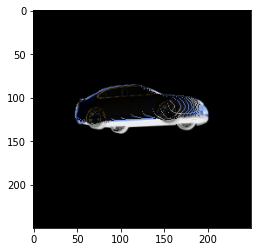

In [180]:
plt.imshow(abs(reconstructed_new_view - rescale_ground_truth_image_target))

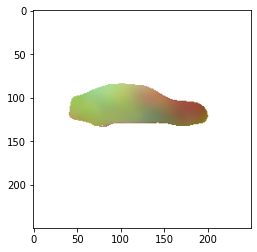

In [9]:
plt.imshow(rendered_image.cpu().numpy())

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import glob
import yaml
import time
import os

from utils import *
from marching_cubes_rgb import *
from scipy import ndimage
from networks import Decoder
from dataLoader import DatasetDecoderSDF2

import IPython

MODEL_ID = 0
MAX_IMAGES = 10
RESOLUTION = 32

# INPUT FILE
SDF_DIR = "../../img_supervision/sdf/"


# IMAGES_PATH = "../../img_supervision/input_images/images/"
# ANNOTATIONS_PATH = "../../img_supervision/input_images/annotations.pkl"
IMAGES_PATH = "../../img_supervision/input_images_validation/images/"
ANNOTATIONS_PATH = "../../img_supervision/input_images_validation/annotations.pkl"
PARAM_FILE = "config/param.yaml"

# SAVE FILE
PLOT_PATH = "../../img_supervision/plots/decoder/visual_hull_SDF/"
DECODER_SDF_PATH = "models_and_codes/decoder_sdf.pth"



def init_weights(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Conv3d)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def init_opt_sched(decoder, param):
    """ initialize optimizer and scheduler"""

    optimizer_decoder = torch.optim.Adam(
        [
            {
                "params": decoder.parameters(),
                "lr": param["eta_decoder"],
            },
        ]
    )

    scheduler_decoder = torch.optim.lr_scheduler.ExponentialLR(optimizer_decoder, gamma=param["gamma_decoder_LR"])

    return optimizer_decoder, scheduler_decoder

def init_xyz(resolution):
    """ fill 3d grid representing 3d location to give as input to the decoder """
    xyz = torch.empty(resolution * resolution * resolution, 3).cuda()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xyz[x * resolution * resolution + y * resolution + z, :] = torch.Tensor([x/(resolution-1)-0.5,y/(resolution-1)-0.5,z/(resolution-1)-0.5])

    return xyz

def compute_loss_sdf(pred_sdf, sdf_gt, threshold_precision, lambda_sdf):
    """ compute sdf, rgb and regression loss """

    loss = torch.nn.MSELoss(reduction='none')

    # assign weight of 0 for easy samples that are well trained
    weight_sdf = ~((pred_sdf > threshold_precision).squeeze() * (sdf_gt > threshold_precision).squeeze()) \
        * ~((pred_sdf < -threshold_precision).squeeze() * (sdf_gt < -threshold_precision).squeeze())

    #L2 loss, only for hard samples
    loss_sdf = loss(pred_sdf.squeeze(), sdf_gt)
    loss_sdf = (loss_sdf * weight_sdf).sum()/weight_sdf.count_nonzero()
    loss_sdf *= lambda_sdf

    return loss_sdf
    
def compute_time_left(time_start, samples_count, num_samples, epoch, num_epoch):
    """ Compute time left until the end of training """
    time_passed = time.time() - time_start
    num_samples_seen = epoch * num_samples + samples_count
    time_per_sample = time_passed/num_samples_seen
    estimate_total_time = time_per_sample * num_epoch * num_samples
    estimate_time_left = estimate_total_time - time_passed

    return estimate_time_left


if __name__ == '__main__':
    print("Loading parameters...")

    # load parameters
    param_all = yaml.safe_load(open(PARAM_FILE))
    param_sdf = param_all["decoder_learning_sdf"]

    # get models' hashs
    list_model_hash = []
    for val in glob.glob(SDF_DIR + "*.h5"):
        list_model_hash.append(os.path.basename(val).split('.')[0])

    annotations = pickle.load(open(ANNOTATIONS_PATH, 'rb'))
    num_images_per_model = len(annotations[list_model_hash[0]])
    num_images = min(num_images_per_model, MAX_IMAGES)

    matrix_world_to_camera = annotations["matrix_world_to_camera"]
    matrix_world_to_camera = matrix_world_to_camera[[1,0,2,3]]
    
    model_id = MODEL_ID
    model_hash = list_model_hash[model_id]
    model_annotations = annotations[model_hash].copy()
    frame = model_annotations[0]["frame"].copy()

    resolution = RESOLUTION
    step = 1/resolution
    threshold_precision = 1/resolution
    num_samples = resolution * resolution * resolution


    print("Loading sihlouettes...")
    for image_id in range(num_images_per_model):
        image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
        input_im = imageio.imread(image_pth)

        mask_car = input_im.mean(2) == 255
        outside_dist = ndimage.distance_transform_edt(mask_car)
        inside_dist = - (ndimage.distance_transform_edt(1 - mask_car) -1)

        model_annotations[image_id]["2d_sdf"] = (outside_dist + inside_dist) / 300



Using skimage's marching cubes implementation.
Loading parameters...
Loading sihlouettes...


In [3]:

print("Computing ground truth SDF...")
latent_code = torch.zeros(6).cuda()
decoder_sdf = torch.load(DECODER_SDF_PATH).cuda()
decoder_sdf.eval()


sdf_gt_estimation = np.empty([resolution, resolution, resolution, 4])
sdf_gt_estimation[:,:,:,0] = -1e42
sdf_gt_estimation[:,:,:,1:] = 1

all_3d_pos = np.empty([resolution, resolution, resolution,3])
color_pix = np.zeros([num_images, resolution, resolution, resolution, 3])
pos_projection = np.zeros([num_images, resolution, resolution, resolution, 3])
direction_vectors = np.zeros([num_images, 3])


for x in range(resolution):
    for y in range(resolution):
        for z in range(resolution):
            pos_3d_ojbect = np.array([-0.5 + x * step, -0.5 + y * step, -0.5 + z * step])
            all_3d_pos[x, y, z] = pos_3d_ojbect

for image_id in range(num_images):

    print(f"Image: {image_id} / {num_images}")

    matrix_object_to_world = model_annotations[image_id]['matrix_object_to_world'].copy()
    matrix_object_to_world = matrix_object_to_world[:,[1,0,2,3]][[2,1,0,3]]

    image_pth = IMAGES_PATH + model_hash + '/' + str(image_id) + '.png'
    input_im = imageio.imread(image_pth)

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                pos_3d_ojbect = all_3d_pos[x,y,z]
                pos_3d_world = matrix_object_to_world[:3,:3].dot(pos_3d_ojbect)
                pos_2d = convert_w2c(matrix_world_to_camera, frame, pos_3d_world)
                pos_2d[:2] *= 300

                try:
                    img_dist = model_annotations[image_id]["2d_sdf"][pos_2d[0].astype(int), pos_2d[1].astype(int)]
                    color_pix[image_id, x, y, z] = input_im[pos_2d[0].astype(int), pos_2d[1].astype(int)]
                except:
                    img_dist = 1e-10

                sdf_estimation_from_image[x,y,z] = img_dist * pos_2d[2]


        pos_init_ray, ray_marching_vector, min_step, max_step = initialize_rendering_from_3d_pos(model_hash, image_id, annotations, all_3d_pos[x].reshape(resolution * resolution, 3))

        pos_init_ray = torch.tensor(pos_init_ray, dtype=torch.float).cuda()
        ray_marching_vector = torch.tensor(ray_marching_vector, dtype=torch.float).cuda()
        min_step = torch.tensor(min_step, dtype=torch.float).cuda()
        max_step = torch.tensor(max_step, dtype=torch.float).cuda()

        pos_along_ray = get_pos_from_ray_marching(decoder_sdf, latent_code, pos_init_ray, ray_marching_vector, min_step, max_step)
        pos_projection[image_id, x] = pos_along_ray.reshape(resolution, resolution, 3).cpu().numpy()

    sdf_gt_estimation[:,:,:,0] = np.maximum(sdf_gt_estimation[:,:,:,0], sdf_estimation_from_image)



print("Fill colors...")

closest_image_idx = np.argmin(np.linalg.norm((pos_projection - all_3d_pos), axis = 4), axis = 0)

for x in range(resolution):
    for y in range(resolution):
        for z in range(resolution):
            sdf_gt_estimation[x,y,z,1:] = color_pix[closest_image_idx[x,y,z], x,y,z]


Computing ground truth SDF...
Image: 0 / 10
Image: 1 / 10
Image: 2 / 10
Image: 3 / 10
Image: 4 / 10
Image: 5 / 10
Image: 6 / 10
Image: 7 / 10
Image: 8 / 10
Image: 9 / 10
Fill colors...


In [4]:

if(np.min(sdf_gt_estimation[:,:,:,0]) < 0 and np.max(sdf_gt_estimation[:,:,:,0]) > 0):
    vertices_pred, faces_pred = marching_cubes(sdf_gt_estimation[:,:,:,0])
    colors_v_pred = exctract_colors_v(vertices_pred, sdf_gt_estimation)
    colors_f_pred = exctract_colors_f(colors_v_pred, faces_pred)
    off_file = "%s/pred_with_colors_%d_%d.off" %(PLOT_PATH, resolution, num_images)
    write_off(off_file, vertices_pred, faces_pred, colors_f_pred)
    with open(PLOT_PATH + f"pred_with_colors_{resolution}_{num_images}.pkl", "wb") as file:
        pickle.dump(sdf_gt_estimation, file)
    print(f"Wrote pred_with_colors_{resolution}_{num_images}.off")
else:
    print("surface level: 0, should be comprise in between the minimum and maximum value")


Wrote pred_with_colors_32_10.off


/home/loic/MasterPDM/codePDM/img_supervision/marching_cubes_rgb.py:100: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, faces, normals, values = measure.marching_cubes_lewiner(tensor.transpose(1, 0, 2), 0)
